# Predict whether or not an Online shopper will buy

Import Necessary libraries

In [45]:
# Standard imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys

# Sklearn
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score


from collections import Counter
from sklearn.utils import resample

from IPython.display import display
pd.set_option('display.max_columns',60)

%matplotlib inline

import warnings
#warnings.filterwarings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

plt.style.use('fivethirtyeight')

import random
random.seed(9001)


Read Data

In [21]:
data = pd.read_csv("Datasets/online_shoppers_intention.csv")
df = data.copy()
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## Data exploration

Counter({False: 10422, True: 1908})


<AxesSubplot:xlabel='Revenue', ylabel='count'>

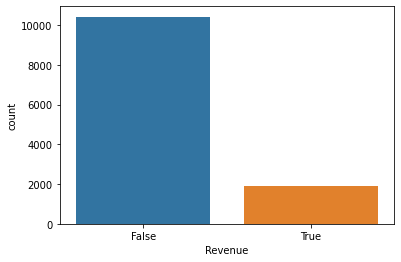

In [12]:
print(Counter(df['Revenue']))
sns.countplot(df['Revenue'])

In [13]:
pd.DataFrame({'Count_Missing': df.isnull().sum(),"Perc_Missing": 100*df.isnull().sum()/len(df)}).sort_values(by = ['Count_Missing'], ascending=False).head(12)

,Count_Missing,Perc_Missing
Administrative,0,0.0
Administrative_Duration,0,0.0
Weekend,0,0.0
VisitorType,0,0.0
TrafficType,0,0.0
Region,0,0.0
Browser,0,0.0
OperatingSystems,0,0.0
Month,0,0.0
SpecialDay,0,0.0


In [14]:
[Counter(df['VisitorType'])]

[Counter({'Returning_Visitor': 10551, 'New_Visitor': 1694, 'Other': 85})]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [16]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,2.315166,3.321784,0.0,0.000000,1.000000,4.000000,27.000000
Administrative_Duration,12330.0,80.818611,176.779107,0.0,0.000000,7.500000,93.256250,3398.750000
Informational,12330.0,0.503569,1.270156,0.0,0.000000,0.000000,0.000000,24.000000
Informational_Duration,12330.0,34.472398,140.749294,0.0,0.000000,0.000000,0.000000,2549.375000
ProductRelated,12330.0,31.731468,44.475503,0.0,7.000000,18.000000,38.000000,705.000000
ProductRelated_Duration,12330.0,1194.746220,1913.669288,0.0,184.137500,598.936905,1464.157213,63973.522230
BounceRates,12330.0,0.022191,0.048488,0.0,0.000000,0.003112,0.016813,0.200000
ExitRates,12330.0,0.043073,0.048597,0.0,0.014286,0.025156,0.050000,0.200000
PageValues,12330.0,5.889258,18.568437,0.0,0.000000,0.000000,0.000000,361.763742
SpecialDay,12330.0,0.061427,0.198917,0.0,0.000000,0.000000,0.000000,1.000000


<AxesSubplot:title={'center':'Distribution of Revenue over Visitortype'}, xlabel='VisitorType'>

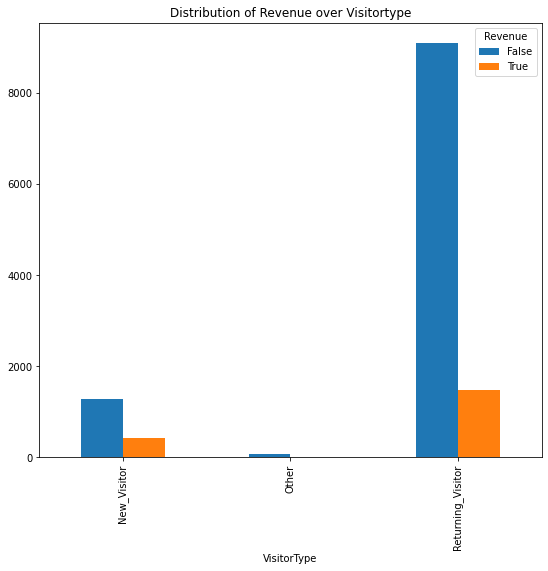

In [18]:
pd.crosstab(df['VisitorType'],df['Revenue']).plot(kind='bar',figsize=(9,8),title="Distribution of Revenue over Visitortype")

/Users/dennisperrett/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'Distribution of Revenue over VisitorType'}, xlabel='VisitorType'>

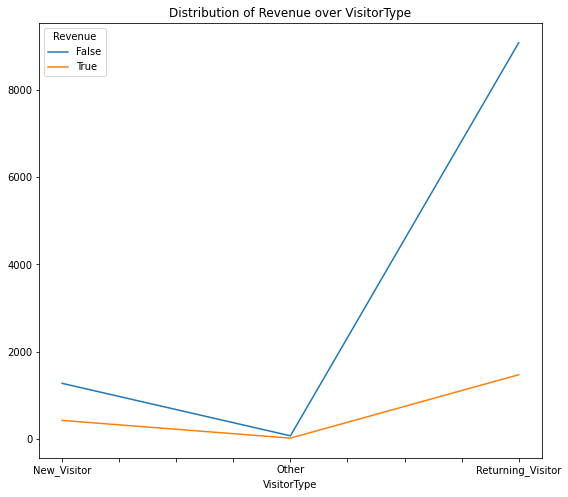

In [20]:
pd.crosstab(df['VisitorType'],df['Revenue']).plot(kind='line',figsize=(9,8),title="Distribution of Revenue over VisitorType")

/Users/dennisperrett/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'Distribtion of Revenue(Target Variable) over Months'}, xlabel='Month'>

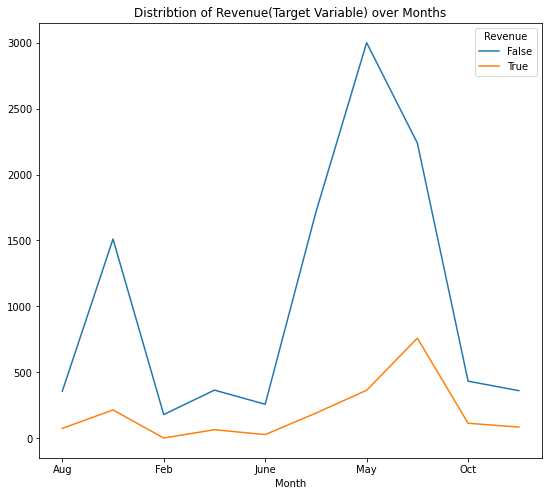

In [23]:
df = df.sort_values('Month')

pd.crosstab(df['Month'],df['Revenue']).plot(kind='line',figsize=(9,8),title="Distribtion of Revenue(Target Variable) over Months")

<AxesSubplot:title={'center':'Distribtion of Revenue(Target Variable) over Months'}, xlabel='Region'>

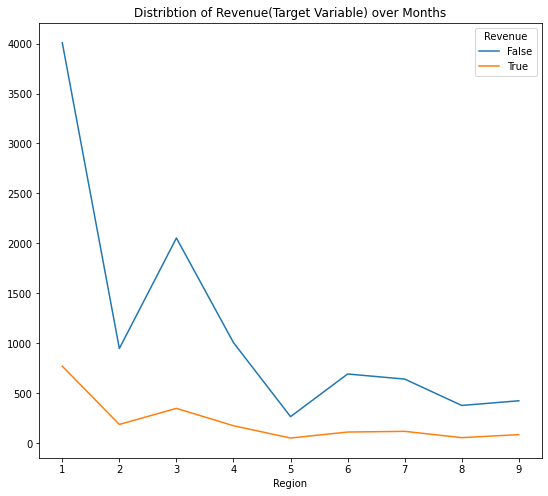

In [24]:
pd.crosstab(df['Region'],df['Revenue']).plot(kind='line',figsize=(9,8),title="Distribtion of Revenue(Target Variable) over Months")

/Users/dennisperrett/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'Distribtion of Revenue(Target Variable) over Months'}, xlabel='Weekend'>

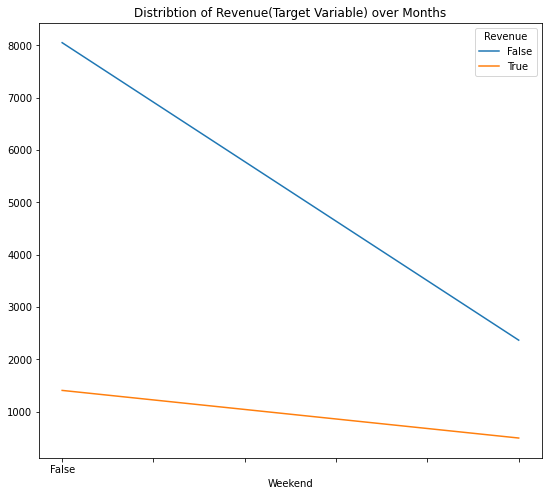

In [25]:
pd.crosstab(df['Weekend'],df['Revenue']).plot(kind='line',figsize=(9,8),title="Distribtion of Revenue(Target Variable) over Months")

<AxesSubplot:title={'center':'Distribtion of Revenue(Target Variable) over Months'}, xlabel='SpecialDay'>

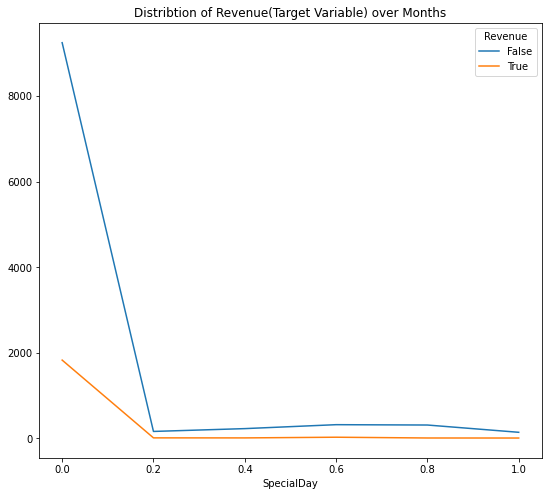

In [27]:
pd.crosstab(df['SpecialDay'],df['Revenue']).plot(kind='line',figsize=(9,8),title="Distribtion of Revenue(Target Variable) over Months")

<AxesSubplot:title={'center':'Distribtion of Revenue(Target Variable) over Months'}, xlabel='PageValues'>

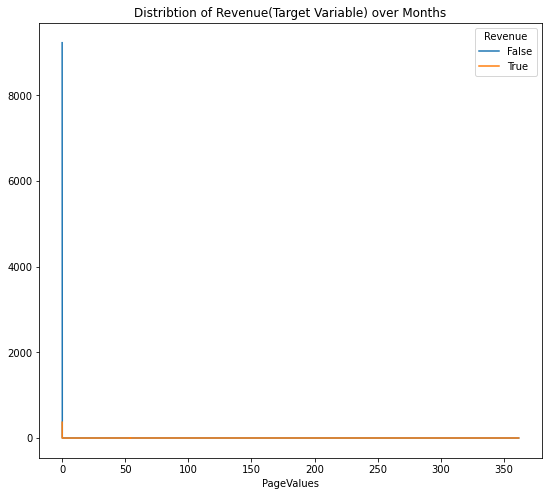

In [29]:
pd.crosstab(df['PageValues'],df['Revenue']).plot(kind='line',figsize=(9,8),title="Distribtion of Revenue(Target Variable) over Months")

<AxesSubplot:title={'center':'Distribtion of Revenue(Target Variable) over Months'}, xlabel='ProductRelated'>

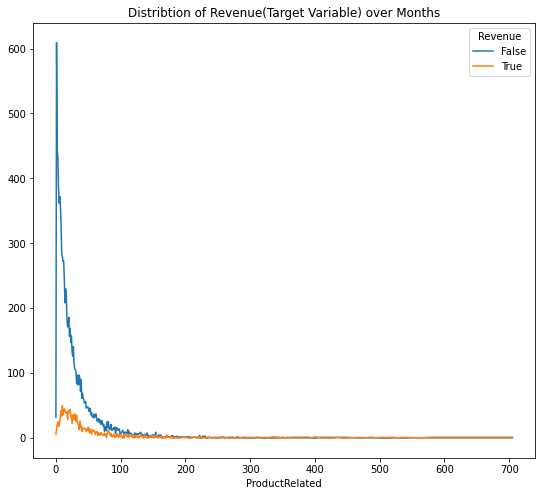

In [30]:
pd.crosstab(df['ProductRelated'],df['Revenue']).plot(kind='line',figsize=(9,8),title="Distribtion of Revenue(Target Variable) over Months")

<AxesSubplot:title={'center':'Distribtion of Revenue(Target Variable) over Months'}, xlabel='BounceRates'>

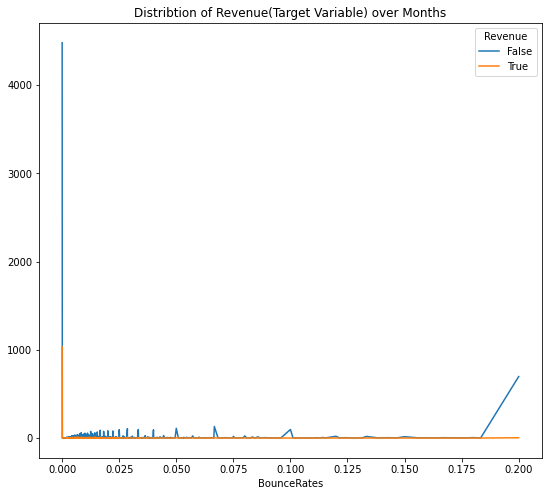

In [32]:
pd.crosstab(df['BounceRates'],df['Revenue']).plot(kind='line',figsize=(9,8),title="Distribtion of Revenue(Target Variable) over Months")

<AxesSubplot:title={'center':'Distribtion of Revenue(Target Variable) over TrafficType'}, xlabel='TrafficType'>

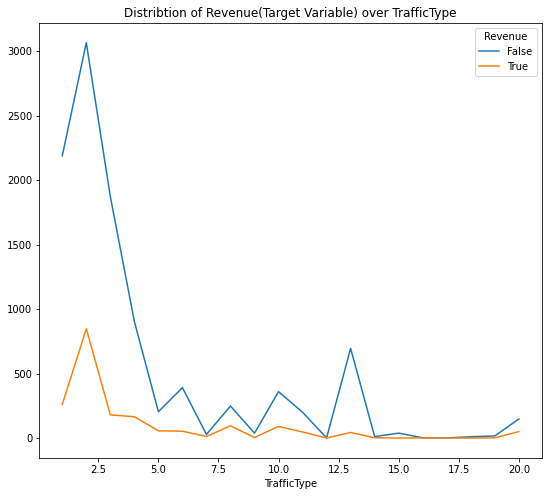

In [33]:
pd.crosstab(df['TrafficType'],df['Revenue']).plot(kind='line',figsize=(9,8),title="Distribtion of Revenue(Target Variable) over TrafficType")

In [22]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,2.315166,3.321784,0.0,0.000000,1.000000,4.000000,27.000000
Administrative_Duration,12330.0,80.818611,176.779107,0.0,0.000000,7.500000,93.256250,3398.750000
Informational,12330.0,0.503569,1.270156,0.0,0.000000,0.000000,0.000000,24.000000
Informational_Duration,12330.0,34.472398,140.749294,0.0,0.000000,0.000000,0.000000,2549.375000
ProductRelated,12330.0,31.731468,44.475503,0.0,7.000000,18.000000,38.000000,705.000000
ProductRelated_Duration,12330.0,1194.746220,1913.669288,0.0,184.137500,598.936905,1464.157213,63973.522230
BounceRates,12330.0,0.022191,0.048488,0.0,0.000000,0.003112,0.016813,0.200000
ExitRates,12330.0,0.043073,0.048597,0.0,0.014286,0.025156,0.050000,0.200000
PageValues,12330.0,5.889258,18.568437,0.0,0.000000,0.000000,0.000000,361.763742
SpecialDay,12330.0,0.061427,0.198917,0.0,0.000000,0.000000,0.000000,1.000000


In [25]:
df = pd.get_dummies(df, columns=['Month'])

In [26]:
df.head().transpose()

,0,1,2,3,4
Administrative,0,0,0,0,0
Administrative_Duration,0,0,0,0,0
Informational,0,0,0,0,0
Informational_Duration,0,0,0,0,0
ProductRelated,1,2,1,2,10
ProductRelated_Duration,0,64,0,2.66667,627.5
BounceRates,0.2,0,0.2,0.05,0.02
ExitRates,0.2,0.1,0.2,0.14,0.05
PageValues,0,0,0,0,0
SpecialDay,0,0,0,0,0


In [27]:
df['Weekend'] = df['Weekend'].astype(int)
df['Revenue'] = df['Revenue'].astype(int)

In [28]:
X = df.drop('Revenue',axis=1)
Y = df['Revenue']

#for idx,column in enumerate(X.columns):
 #   plt.figure(idx)
  #  X.hist(column=column,grid=True);

In [15]:
X.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,1,0,0,1


## Check for Collinearity between features
### (High correlation between variables)

In [29]:
X.head().transpose()

,0,1,2,3,4
Administrative,0.0,0.0,0.0,0.000000,0.00
Administrative_Duration,0.0,0.0,0.0,0.000000,0.00
Informational,0.0,0.0,0.0,0.000000,0.00
Informational_Duration,0.0,0.0,0.0,0.000000,0.00
ProductRelated,1.0,2.0,1.0,2.000000,10.00
ProductRelated_Duration,0.0,64.0,0.0,2.666667,627.50
BounceRates,0.2,0.0,0.2,0.050000,0.02
ExitRates,0.2,0.1,0.2,0.140000,0.05
PageValues,0.0,0.0,0.0,0.000000,0.00
SpecialDay,0.0,0.0,0.0,0.000000,0.00


In [132]:
def AvgMinutes(Count,Duration):
    """Calcluate the Avg Minutes for the specific columns"""
    if Duration == 0:
        output = 0
    elif Duration != 0:
        output = float(Duration)/float(Count)
    return output

Columns = [['Administrative','Administrative_Duration'],
           ['Informational','Informational_Duration'],
           ['ProductRelated','ProductRelated_Duration']]

X['AvgAdministrative'] = X.apply(lambda x:AvgMinutes(Count=x['Administrative'],Duration=x['Administrative_Duration']),axis=1)
X['AvgInformational'] = X.apply(lambda x:AvgMinutes(Count=x['Informational'],Duration=x['Informational_Duration']),axis=1)
X['AvgProductRelated'] = X.apply(lambda x:AvgMinutes(Count=x['ProductRelated'],Duration=x['ProductRelated_Duration']),axis=1)

X.drop(['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration'], axis=1, inplace=True)


    
    
    
    

KeyError: 'Administrative'

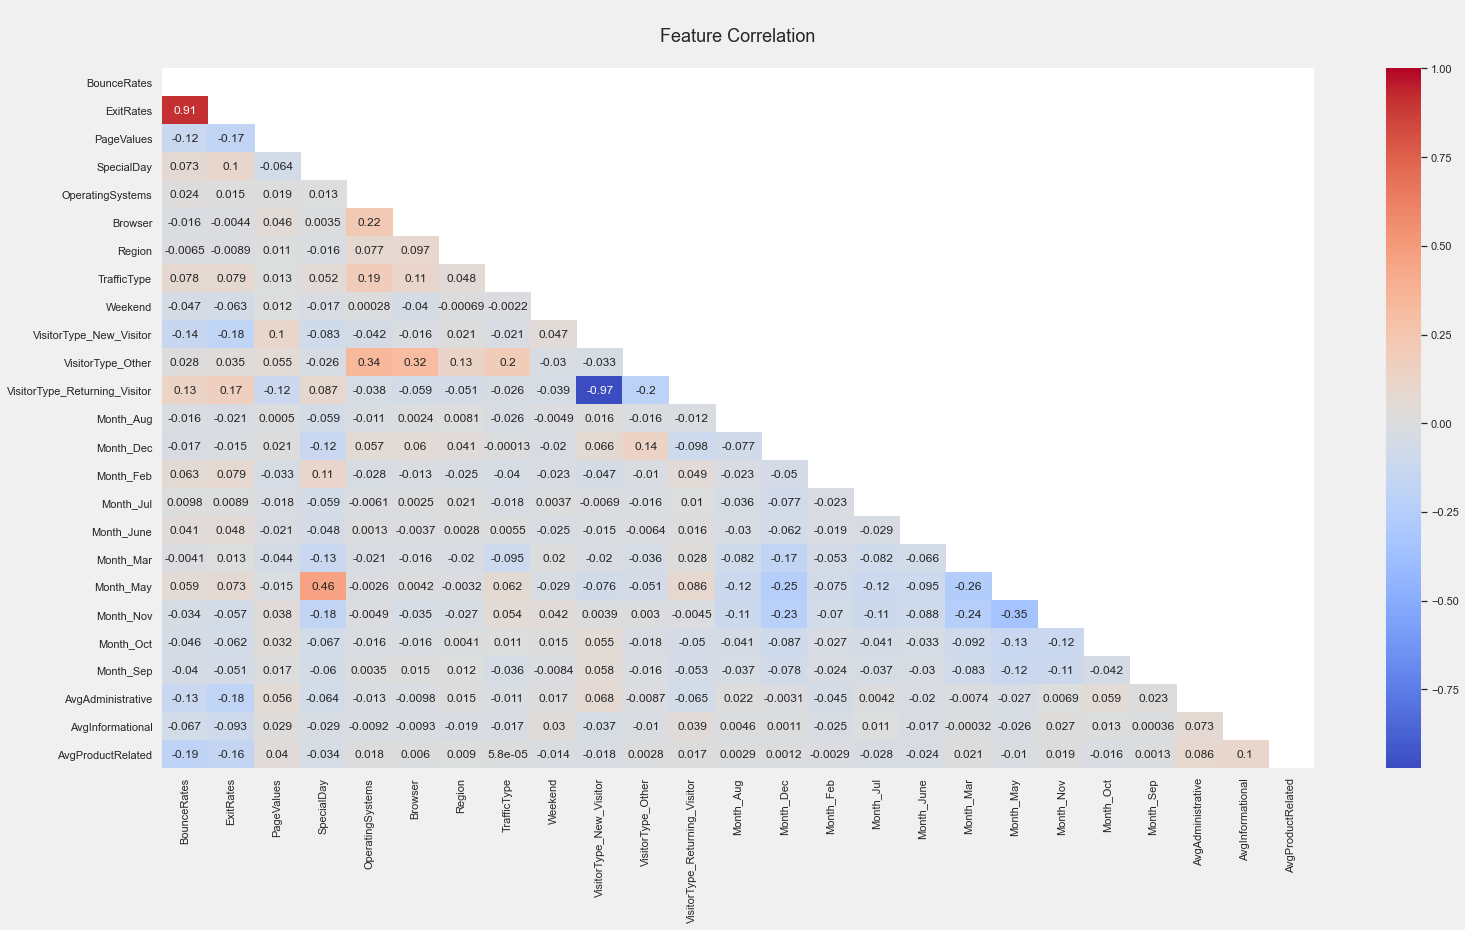

In [46]:
def half_masked_corr_heatmap(X,title=None,file=None):
    """Plots the Half mased Pearsons Correlation Graph"""
    plt.figure(figsize=(23,12))
    sns.set(font_scale=1)
    
    mask = np.zeros_like(X.corr())
    mask[np.triu_indices_from(mask)] = True
    
    with sns.axes_style('white'):
        sns.heatmap(X.corr(),mask = mask, annot = True, cmap='coolwarm')
        
        if title: plt.title(f'\n{title}\n',fontsize=18)
        plt.xlabel('')
        plt.ylabel('')
        if file: plt.savefig(file,bbox_inches='tight')
        plt.show()
        
        return
    
half_masked_corr_heatmap(X,"Feature Correlation")

## Linear Model with All Features

In [47]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2)

print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

features = df.columns[:-1]

(9864, 25) (2466, 25)
(9864,) (2466,)


In [49]:
result_dict = {}
# Helper function to summarise

def summarise_classification(y_test,y_pred):
    """Summarises each test"""
    acc = accuracy_score(y_test,y_pred,normalize=True)
    num_acc = accuracy_score(y_test,y_pred,normalize=True)
    
    prec = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    F1_score = f1_score(y_test,y_pred)
    auc_score = roc_auc_score(y_test,y_pred)
    
    return{
        'Accuracy': acc,
        'Accuracy_count': num_acc,
        'Precision': prec,
        'Recall': recall,
        'F1_Score': F1_score,
        'AUC_ROC': auc_score
    }

In [56]:
# Helper Function to Build Model
def build_model(classifier_fn,
               name_of_y_col,
               name_of_x_cols,
               dataset,test_frac=0.2,
               show_plot_auc=None):
    """Builds end to end model and share the model summary.
    If show_plot_auc==True: Plot the AUC - ROC Curve"""
    
    # Separating the input features (X) and target Variable (Y)
    X = df.drop('Revenue',axis=1)
    Y = df['Revenue']
    
    # Feature Scaling
    scale_x = StandardScaler()
    x = scale_x.fit_transform(X)
    
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=0)
    
    model = classifier_fn(x_train,y_train)
    
    y_pred = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    
    train_summary = summarise_classification(y_train,y_pred_train)
    test_summary = summarise_classification(y_test,y_pred)
    
    pred_result = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
    
    model_crosstab = pd.crosstab(pred_result.y_pred,pred_result.y_test)
    
    if show_plot_auc==True:
        plt.figure(figsize=(8,6))
        
        logit_roc_auc1 = roc_auc_score(y_train, model.predict(x_train))
        fpr1, trp1, thresholds1 = roc_curve(y_train, model.predict_proba(x_train)[:,1])
        plt.plot(fpr1, trp1, label="Class_Train *AUC = %0.2f)" % logit_roc_auc1)
    
        logit_roc_auc2 = roc_auc_score(y_test, model.predict(x_test))
        fpr2, trp2, thresholds2 = roc_curve(y_test, model.predict_proba(x_test)[:,1])
        plt.plot(fpr2, trp2, label="Class_Test *AUC = %0.2f)" % logit_roc_auc2)
    
        plt.plot([0,1],[0,1],"r--")
        plt.xlim([0.0,1.0])
        plt.ylim([0.0,1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver operating characteristic(ROC-AUC)")
        plt.legend(loc="lower right")
        plt.show()
        
        return{'training':train_summary,
              'test':test_summary,
              'confusion_matrix':model_crosstab
              }
    

In [51]:
# Helper function to compare the score of different Model
def compare_result():
    """
    Shows Train the Test data summary for all the Model runned in form of data dictionary
    """
    
    for key in result_dict:
        print('Classification: ',key)
        print()
        print('Training data:-')
        for score in result_dict[key]['training']:
            print(score, result_dict[key]['training'][score])
            
        print()
        print('Test data:-')
        for score in result_dict[key]['test']:
            print(score,result_dict[key]['test'][score])
            
        print()

# Model 1: Logistic Regression

In [52]:
def logistic_fn(x_train,y_train):
    """Function to build logit Model for the given dataset"""
    model = LogisticRegression(solver='liblinear',random_state=12)
    model.fit(x_train,y_train)
    
    return model

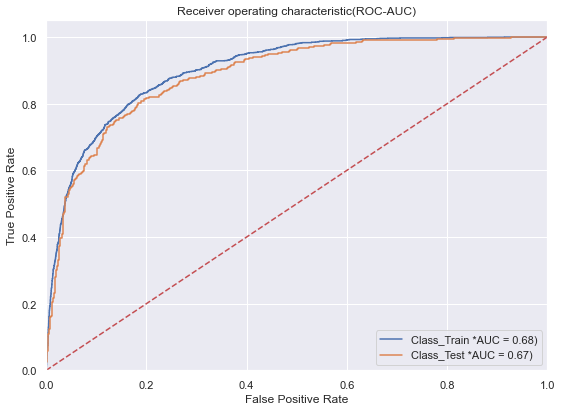

In [57]:
result_dict['Revenue ~ Logistic'] = \
    build_model(logistic_fn,'Revenue',features,df,show_plot_auc=True)

In [58]:
compare_result()

Classification:  Revenue ~ Logistic

Training data:-
Accuracy 0.8868613138686131
Accuracy_count 0.8868613138686131
Precision 0.7453580901856764
Recall 0.3781965006729475
F1_Score 0.5017857142857143
AUC_ROC 0.6776396683359963

Test data:-
Accuracy 0.8706407137064072
Accuracy_count 0.8706407137064072
Precision 0.7417840375586855
Recall 0.3744075829383886
F1_Score 0.4976377952755906
AUC_ROC 0.6737497797275113



In [60]:
def logistic_CV_fn(x_train,y_train):
    """
    Function to build Logistic Model using the Cross Validation of 10 folds for the given dataset
    """
    
    model = LogisticRegressionCV(cv=10, random_state=12,solver='liblinear')
    model.fit(x_train,y_train)
    
    return model

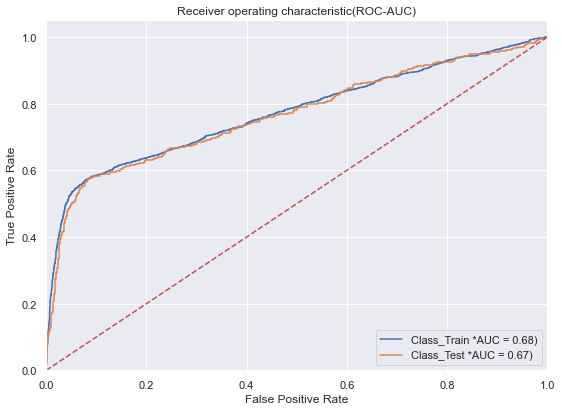

In [91]:
result_dict['Revenue ~ Logistic_CV'] = build_model(logistic_CV_fn,'Revenue',features,df,show_plot_auc=True)

In [62]:
compare_result()

Classification:  Revenue ~ Logistic

Training data:-
Accuracy 0.8868613138686131
Accuracy_count 0.8868613138686131
Precision 0.7453580901856764
Recall 0.3781965006729475
F1_Score 0.5017857142857143
AUC_ROC 0.6776396683359963

Test data:-
Accuracy 0.8706407137064072
Accuracy_count 0.8706407137064072
Precision 0.7417840375586855
Recall 0.3744075829383886
F1_Score 0.4976377952755906
AUC_ROC 0.6737497797275113

Classification:  Revenue ~ Logistc_CV

Training data:-
Accuracy 0.887875101378751
Accuracy_count 0.887875101378751
Precision 0.75
Recall 0.3835800807537012
F1_Score 0.5075690115761352
AUC_ROC 0.6804508186055448

Test data:-
Accuracy 0.8690186536901865
Accuracy_count 0.8690186536901865
Precision 0.7438423645320197
Recall 0.3578199052132701
F1_Score 0.48319999999999996
AUC_ROC 0.6661897960508621



<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Value of k for KNN')

Text(0, 0.5, 'Cross-Validated Accuracy')

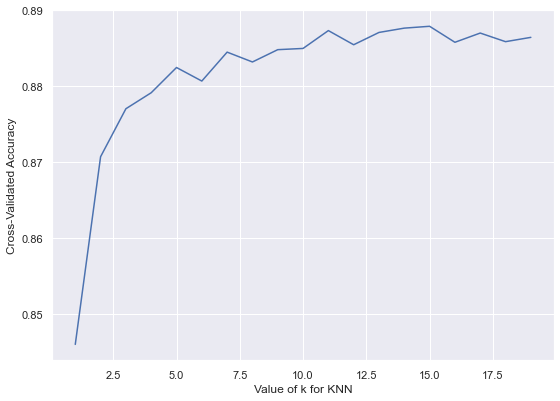

[(1, 0.8459854014598541),
 (2, 0.8707218167072183),
 (3, 0.8770478507704785),
 (4, 0.8791565287915653),
 (5, 0.8824817518248175),
 (6, 0.8806974858069747),
 (7, 0.8845093268450933),
 (8, 0.8832116788321167),
 (9, 0.8848337388483374),
 (10, 0.8849959448499594),
 (11, 0.8873479318734795),
 (12, 0.8854825628548255),
 (13, 0.8871046228710462),
 (14, 0.8876723438767234),
 (15, 0.8879156528791565),
 (16, 0.8858069748580697),
 (17, 0.8870235198702352),
 (18, 0.8858880778588807),
 (19, 0.8864557988645579)]

In [65]:
# Plot to check best value for k to chose based on the accuracy score

k_range = range(1,20)
k_scores = []

# Use iteration to calculator different k in models, then return the average accuracy based on the cross validation

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, Y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
    
# Plot to see clearly
plt.figure(figsize=(8,6))
plt.plot(k_range, k_scores)
plt.xlabel('Value of k for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

list(enumerate(k_scores,1))

In [66]:
def knn_fn(x_train,y_train,n_neighbors=9,random_state=12):
    """
    Function to build KNN Model for the given dataset
    """
    
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(x_train,y_train)
    
    return model

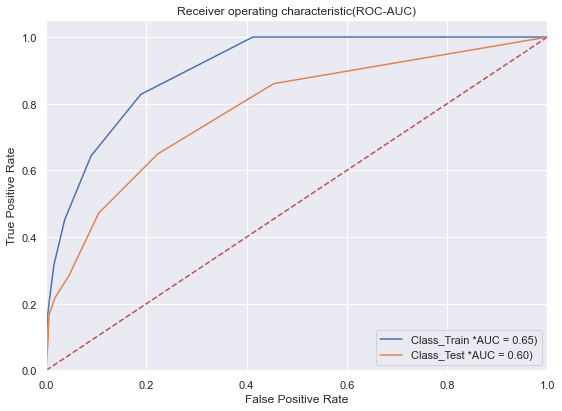

In [67]:
result_dict['Revenue ~ KNN'] = \
    build_model(knn_fn,'Revenue',features,df,show_plot_auc=True)

In [68]:
compare_result()

Classification:  Revenue ~ Logistic

Training data:-
Accuracy 0.8868613138686131
Accuracy_count 0.8868613138686131
Precision 0.7453580901856764
Recall 0.3781965006729475
F1_Score 0.5017857142857143
AUC_ROC 0.6776396683359963

Test data:-
Accuracy 0.8706407137064072
Accuracy_count 0.8706407137064072
Precision 0.7417840375586855
Recall 0.3744075829383886
F1_Score 0.4976377952755906
AUC_ROC 0.6737497797275113

Classification:  Revenue ~ Logistc_CV

Training data:-
Accuracy 0.887875101378751
Accuracy_count 0.887875101378751
Precision 0.75
Recall 0.3835800807537012
F1_Score 0.5075690115761352
AUC_ROC 0.6804508186055448

Test data:-
Accuracy 0.8690186536901865
Accuracy_count 0.8690186536901865
Precision 0.7438423645320197
Recall 0.3578199052132701
F1_Score 0.48319999999999996
AUC_ROC 0.6661897960508621

Classification:  Revenue ~ KNN

Training data:-
Accuracy 0.8839213300892133
Accuracy_count 0.8839213300892133
Precision 0.7846410684474123
Recall 0.3162853297442799
F1_Score 0.450839328537170

In [71]:
def naive_bayes_fn(x_train,y_train, priors=None):
    """
    Function for Naive Bayes Model
    """
    model = GaussianNB(priors=priors)
    model.fit(x_train,y_train)
    
    return model

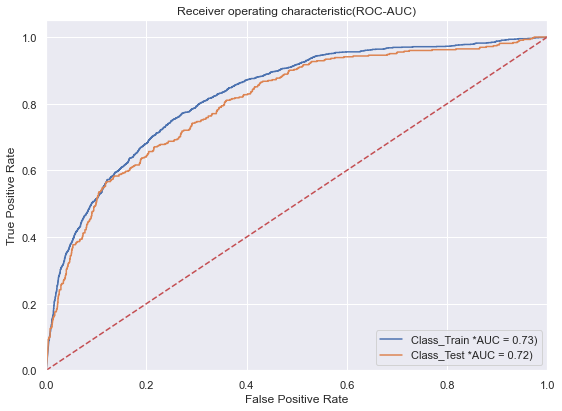

Classification:  Revenue ~ Logistic

Training data:-
Accuracy 0.8868613138686131
Accuracy_count 0.8868613138686131
Precision 0.7453580901856764
Recall 0.3781965006729475
F1_Score 0.5017857142857143
AUC_ROC 0.6776396683359963

Test data:-
Accuracy 0.8706407137064072
Accuracy_count 0.8706407137064072
Precision 0.7417840375586855
Recall 0.3744075829383886
F1_Score 0.4976377952755906
AUC_ROC 0.6737497797275113

Classification:  Revenue ~ KNN

Training data:-
Accuracy 0.8839213300892133
Accuracy_count 0.8839213300892133
Precision 0.7846410684474123
Recall 0.3162853297442799
F1_Score 0.4508393285371702
AUC_ROC 0.6504439300905692

Test data:-
Accuracy 0.851581508515815
Accuracy_count 0.851581508515815
Precision 0.71875
Recall 0.21800947867298578
F1_Score 0.3345454545454546
AUC_ROC 0.6001984771055732

Classification:  Revenue ~ Random_Forest

Training data:-
Accuracy 0.9869221411192214
Accuracy_count 0.9869221411192214
Precision 0.9956172388604821
Recall 0.9172274562584118
F1_Score 0.954816112

In [96]:
result_dict['Revenue ~ Naive_Bayes'] = \
    build_model(naive_bayes_fn,'Revenue',features,df,show_plot_auc=True)

compare_result()

In [76]:
def random_forest_fn(x_train,y_train):
    """
    Build random forest model
    """
    
    model = RandomForestClassifier(n_estimators=50,max_depth=15, random_state=12)
    model.fit(x_train,y_train)
    
    return model

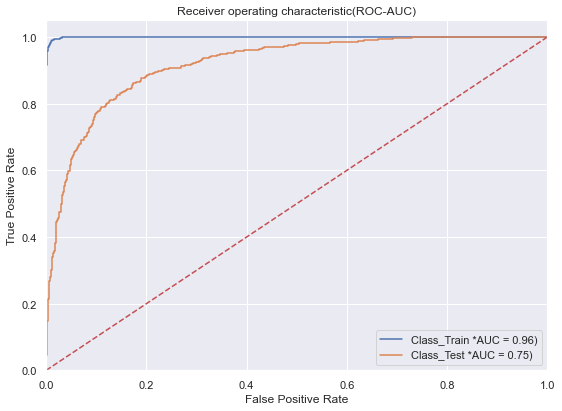

In [77]:
result_dict['Revenue ~ Random_Forest'] = \
    build_model(random_forest_fn,'Revenue',features,df,show_plot_auc=True)

In [78]:
compare_result()

Classification:  Revenue ~ Logistic

Training data:-
Accuracy 0.8868613138686131
Accuracy_count 0.8868613138686131
Precision 0.7453580901856764
Recall 0.3781965006729475
F1_Score 0.5017857142857143
AUC_ROC 0.6776396683359963

Test data:-
Accuracy 0.8706407137064072
Accuracy_count 0.8706407137064072
Precision 0.7417840375586855
Recall 0.3744075829383886
F1_Score 0.4976377952755906
AUC_ROC 0.6737497797275113

Classification:  Revenue ~ Logistc_CV

Training data:-
Accuracy 0.887875101378751
Accuracy_count 0.887875101378751
Precision 0.75
Recall 0.3835800807537012
F1_Score 0.5075690115761352
AUC_ROC 0.6804508186055448

Test data:-
Accuracy 0.8690186536901865
Accuracy_count 0.8690186536901865
Precision 0.7438423645320197
Recall 0.3578199052132701
F1_Score 0.48319999999999996
AUC_ROC 0.6661897960508621

Classification:  Revenue ~ KNN

Training data:-
Accuracy 0.8839213300892133
Accuracy_count 0.8839213300892133
Precision 0.7846410684474123
Recall 0.3162853297442799
F1_Score 0.450839328537170

In [99]:
training_score = pd.DataFrame({
'Model Name':['Train_Logistic','Train_Logistic_CV','Train_KNN','Train_Naive_Bayes','Random_Forest'],
    
'N_Observation':[len(x_train),len(x_train),len(x_train),len(x_train),len(x_train)],
    
'Accuracy':[result_dict['Revenue ~ Logistic']['training']['Accuracy']*100,
            result_dict['Revenue ~ Logistic_CV']['training']['Accuracy']*100,
            result_dict['Revenue ~ KNN']['training']['Accuracy']*100,
            result_dict['Revenue ~ Naive_Bayes']['training']['Accuracy']*100,
            result_dict['Revenue ~ Random_Forest']['training']['Accuracy']*100],
             
'Accu_Count':[result_dict['Revenue ~ Logistic']['training']['Accuracy_count'],
            result_dict['Revenue ~ Logistic_CV']['training']['Accuracy_count'],
            result_dict['Revenue ~ KNN']['training']['Accuracy_count'],
            result_dict['Revenue ~ Naive_Bayes']['training']['Accuracy_count'],
            result_dict['Revenue ~ Random_Forest']['training']['Accuracy_count']],
    
'Precision':[result_dict['Revenue ~ Logistic']['training']['Precision']*100,
            result_dict['Revenue ~ Logistic_CV']['training']['Precision']*100,
            result_dict['Revenue ~ KNN']['training']['Precision']*100,
            result_dict['Revenue ~ Naive_Bayes']['training']['Precision']*100,
            result_dict['Revenue ~ Random_Forest']['training']['Precision']*100],

'Recall':[result_dict['Revenue ~ Logistic']['training']['Recall']*100,
            result_dict['Revenue ~ Logistic_CV']['training']['Recall']*100,
            result_dict['Revenue ~ KNN']['training']['Recall']*100,
            result_dict['Revenue ~ Naive_Bayes']['training']['Recall']*100,
            result_dict['Revenue ~ Random_Forest']['training']['Recall']*100],

'F1_score':[result_dict['Revenue ~ Logistic']['training']['F1_Score']*100,
            result_dict['Revenue ~ Logistic_CV']['training']['F1_Score']*100,
            result_dict['Revenue ~ KNN']['training']['F1_Score']*100,
            result_dict['Revenue ~ Naive_Bayes']['training']['F1_Score']*100,
            result_dict['Revenue ~ Random_Forest']['training']['F1_Score']*100],
    
'AUC_ROC':[result_dict['Revenue ~ Logistic']['training']['AUC_ROC']*100,
            result_dict['Revenue ~ Logistic_CV']['training']['AUC_ROC']*100,
            result_dict['Revenue ~ KNN']['training']['AUC_ROC']*100,
            result_dict['Revenue ~ Naive_Bayes']['training']['AUC_ROC']*100,
            result_dict['Revenue ~ Random_Forest']['training']['AUC_ROC']*100]
    
                })

test_score = pd.DataFrame({
'Model Name':['Test_Logistic','Test_Logistic_CV','Test_KNN','Test_Naive_Bayes','Random_Forest'],
    
'N_Observation':[len(x_test),len(x_test),len(x_test),len(x_test),len(x_test)],
    
'Accuracy':[result_dict['Revenue ~ Logistic']['test']['Accuracy']*100,
            result_dict['Revenue ~ Logistic_CV']['test']['Accuracy']*100,
            result_dict['Revenue ~ KNN']['test']['Accuracy']*100,
            result_dict['Revenue ~ Naive_Bayes']['test']['Accuracy']*100,
            result_dict['Revenue ~ Random_Forest']['test']['Accuracy']*100],
             
'Accu_Count':[result_dict['Revenue ~ Logistic']['test']['Accuracy_count'],
            result_dict['Revenue ~ Logistic_CV']['test']['Accuracy_count'],
            result_dict['Revenue ~ KNN']['test']['Accuracy_count'],
            result_dict['Revenue ~ Naive_Bayes']['test']['Accuracy_count'],
            result_dict['Revenue ~ Random_Forest']['test']['Accuracy_count']],
    
'Precision':[result_dict['Revenue ~ Logistic']['test']['Precision']*100,
            result_dict['Revenue ~ Logistic_CV']['test']['Precision']*100,
            result_dict['Revenue ~ KNN']['test']['Precision']*100,
            result_dict['Revenue ~ Naive_Bayes']['test']['Precision']*100,
            result_dict['Revenue ~ Random_Forest']['test']['Precision']*100],

'Recall':[result_dict['Revenue ~ Logistic']['test']['Recall']*100,
            result_dict['Revenue ~ Logistic_CV']['test']['Recall']*100,
            result_dict['Revenue ~ KNN']['test']['Recall']*100,
            result_dict['Revenue ~ Naive_Bayes']['test']['Recall']*100,
            result_dict['Revenue ~ Random_Forest']['test']['Recall']*100],

'F1_score':[result_dict['Revenue ~ Logistic']['test']['F1_Score']*100,
            result_dict['Revenue ~ Logistic_CV']['test']['F1_Score']*100,
            result_dict['Revenue ~ KNN']['test']['F1_Score']*100,
            result_dict['Revenue ~ Naive_Bayes']['test']['F1_Score']*100,
            result_dict['Revenue ~ Random_Forest']['test']['F1_Score']*100],
    
'AUC_ROC':[result_dict['Revenue ~ Logistic']['test']['AUC_ROC']*100,
            result_dict['Revenue ~ Logistic_CV']['test']['AUC_ROC']*100,
            result_dict['Revenue ~ KNN']['test']['AUC_ROC']*100,
            result_dict['Revenue ~ Naive_Bayes']['test']['AUC_ROC']*100,
            result_dict['Revenue ~ Random_Forest']['test']['AUC_ROC']*100],
                })
           
print("Below are the Training scores for all Models:")
display(training_score.set_index(['Model Name']).sort_values(by=['Accuracy'],ascending=False))  
print()
print("Below are the Test scores for all Models:")
display(test_score.set_index(['Model Name']).sort_values(by=['Accuracy'],ascending=False))

Below are the Training scores for all Models:


,N_Observation,Accuracy,Accu_Count,Precision,Recall,F1_score,AUC_ROC
Model Name,,,,,,,
Random_Forest,9864,98.692214,0.986922,99.561724,91.722746,95.481611,95.825565
Train_Logistic_CV,9864,88.787510,0.887875,75.000000,38.358008,50.756901,68.045082
Train_Logistic,9864,88.686131,0.886861,74.535809,37.819650,50.178571,67.763967
Train_KNN,9864,88.392133,0.883921,78.464107,31.628533,45.083933,65.044393
Train_Naive_Bayes,9864,79.825629,0.798256,39.578164,64.401077,49.026639,73.481274



Below are the Test scores for all Models:


,N_Observation,Accuracy,Accu_Count,Precision,Recall,F1_score,AUC_ROC
Model Name,,,,,,,
Random_Forest,2466,89.213301,0.892133,76.712329,53.080569,62.745098,74.876879
Test_Logistic,2466,87.064071,0.870641,74.178404,37.440758,49.763780,67.374978
Test_Logistic_CV,2466,86.901865,0.869019,74.384236,35.781991,48.320000,66.618980
Test_KNN,2466,85.158151,0.851582,71.875000,21.800948,33.454545,60.019848
Test_Naive_Bayes,2466,78.994323,0.789943,42.156863,61.137441,49.903288,71.909229


In [98]:
result_dict

{'Revenue ~ Logistic': {'training': {'Accuracy': 0.8868613138686131,
   'Accuracy_count': 0.8868613138686131,
   'Precision': 0.7453580901856764,
   'Recall': 0.3781965006729475,
   'F1_Score': 0.5017857142857143,
   'AUC_ROC': 0.6776396683359963},
  'test': {'Accuracy': 0.8706407137064072,
   'Accuracy_count': 0.8706407137064072,
   'Precision': 0.7417840375586855,
   'Recall': 0.3744075829383886,
   'F1_Score': 0.4976377952755906,
   'AUC_ROC': 0.6737497797275113},
  'confusion_matrix': y_test     0    1
  y_pred           
  0       1989  264
  1         55  158},
 'Revenue ~ KNN': {'training': {'Accuracy': 0.8839213300892133,
   'Accuracy_count': 0.8839213300892133,
   'Precision': 0.7846410684474123,
   'Recall': 0.3162853297442799,
   'F1_Score': 0.4508393285371702,
   'AUC_ROC': 0.6504439300905692},
  'test': {'Accuracy': 0.851581508515815,
   'Accuracy_count': 0.851581508515815,
   'Precision': 0.71875,
   'Recall': 0.21800947867298578,
   'F1_Score': 0.3345454545454546,
   'AU

# Feature Importance using XGBoost

In [100]:
model = XGBClassifier()
model.fit(x_train,y_train)

XGBoost_eval_metric_y_pred = model.predict(x_test)

summarise_classification(y_test,XGBoost_eval_metric_y_pred)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

{'Accuracy': 0.9030819140308192,
 'Accuracy_count': 0.9030819140308192,
 'Precision': 0.7046979865771812,
 'Recall': 0.5817174515235457,
 'F1_Score': 0.637329286798179,
 'AUC_ROC': 0.7699561129351695}

In [103]:
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
print(model.feature_importances_)

[0.05673982 0.02453543 0.42290455 0.         0.00801213 0.00695994
 0.00725387 0.01156535 0.01879049 0.02199412 0.         0.0890117
 0.00499131 0.02525313 0.00620586 0.00855877 0.         0.05555991
 0.0677633  0.07691806 0.0113998  0.01845447 0.02852359 0.01252017
 0.01608432]


In [107]:
feature_dict={}
for features in zip(df.columns[:-1],model.feature_importances_):
    feature_dict[f"{features[0]}"]=features[1]

In [110]:
feature_dict

{'Administrative': 0.05673982,
 'Administrative_Duration': 0.024535425,
 'Informational': 0.42290455,
 'Informational_Duration': 0.0,
 'ProductRelated': 0.008012126,
 'ProductRelated_Duration': 0.006959944,
 'BounceRates': 0.0072538666,
 'ExitRates': 0.011565345,
 'PageValues': 0.018790495,
 'SpecialDay': 0.021994118,
 'OperatingSystems': 0.0,
 'Browser': 0.0890117,
 'Region': 0.004991309,
 'TrafficType': 0.02525313,
 'Weekend': 0.0062058643,
 'Revenue': 0.008558766,
 'VisitorType_New_Visitor': 0.0,
 'VisitorType_Other': 0.055559907,
 'VisitorType_Returning_Visitor': 0.0677633,
 'Month_Aug': 0.07691806,
 'Month_Dec': 0.011399796,
 'Month_Feb': 0.018454468,
 'Month_Jul': 0.028523589,
 'Month_June': 0.0125201745,
 'Month_Mar': 0.016084317}

In [123]:
features = pd.DataFrame.from_dict(feature_dict, orient='index')

In [124]:
features['Score'] = features.pop(0)
features.reset_index(level=0,inplace=True)

In [130]:
features = features.sort_values('Score',ascending=False)
features

,Score,Feature
2,0.422905,Informational
11,0.089012,Browser
19,0.076918,Month_Aug
18,0.067763,VisitorType_Returning_Visitor
0,0.056740,Administrative
17,0.055560,VisitorType_Other
22,0.028524,Month_Jul
13,0.025253,TrafficType
1,0.024535,Administrative_Duration
9,0.021994,SpecialDay


<AxesSubplot:ylabel='Feature'>

Text(0.5, 0, 'Score')

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, 'Informational'),
  Text(0, 1, 'Browser'),
  Text(0, 2, 'Month_Aug'),
  Text(0, 3, 'VisitorType_Returning_Visitor'),
  Text(0, 4, 'Administrative'),
  Text(0, 5, 'VisitorType_Other'),
  Text(0, 6, 'Month_Jul'),
  Text(0, 7, 'TrafficType'),
  Text(0, 8, 'Administrative_Duration'),
  Text(0, 9, 'SpecialDay'),
  Text(0, 10, 'PageValues'),
  Text(0, 11, 'Month_Feb'),
  Text(0, 12, 'Month_Mar'),
  Text(0, 13, 'Month_June'),
  Text(0, 14, 'ExitRates'),
  Text(0, 15, 'Month_Dec'),
  Text(0, 16, 'Revenue'),
  Text(0, 17, 'ProductRelated'),
  Text(0, 18, 'BounceRates'),
  Text(0, 19, 'ProductRelated_Duration'),
  Text(0, 20, 'Weekend'),
  Text(0, 21, 'Region'),
  Text(0, 22, 'OperatingSystems'),
  Text(0, 23, 'VisitorType_New_Visitor'),
  Text(0, 24, 'Informational_Duration')])

Text(0, 0.5, 'Feature Importance Score')

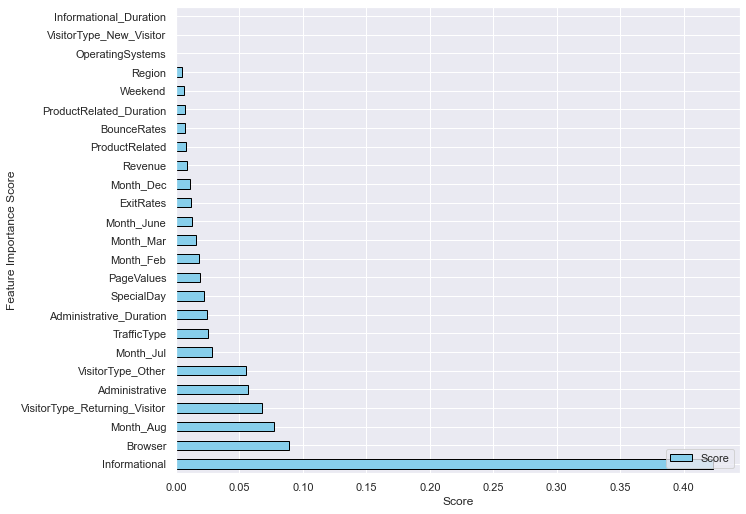

In [131]:
features.plot(x='Feature',y='Score',kind='barh',color='skyblue',edgecolor='black',figsize=(9,8))

# Plot formatting
plt.xlabel('Score')
plt.xticks()
plt.yticks()
plt.ylabel('Feature Importance Score')
plt.legend(loc="lower right")
plt.show()

In [134]:
## Finding Important Features then Removing from DataFrame
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

list_one = []
feature_ranking = SelectKBest(chi2,k=5)
fit = feature_ranking.fit(X,Y)

for i, (score, feature) in enumerate(zip(feature_ranking.scores_,X.columns)):
    list_one.append((score,feature))
    
dfObj = pd.DataFrame(list_one)
dfObj.sort_values(by=[0],ascending=False)

X .drop(['Month_Aug','TrafficType','OperatingSystems','VisitorType_Other','Month_Jul'],axis=1,inplace=True)

,0,1
2,175126.808512,PageValues
23,10662.599140,AvgInformational
22,6829.412944,AvgAdministrative
24,1143.263922,AvgProductRelated
19,223.548231,Month_Nov
9,115.339482,VisitorType_New_Visitor
18,54.997108,Month_May
3,53.797094,SpecialDay
17,42.613274,Month_Mar
0,29.654336,BounceRates
